In [53]:
# Import necessary libraries
import cv2
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from tensorflow.keras.models import load_model
from patchify import patchify, unpatchify

In [54]:
# Specify the desired working directory
my_directory = r'C:\Users\User\Desktop\2023-24b-fai2-adsai-yuliiabobrovytska226038\1. Computer Vision\DataLab tasks\Task 4'

# Change the working directory
os.chdir(my_directory)

# Print the updated working directory
print("My working directory:", os.getcwd())

My working directory: C:\Users\User\Desktop\2023-24b-fai2-adsai-yuliiabobrovytska226038\1. Computer Vision\DataLab tasks\Task 4


In [55]:
parent_dir = "Dataset"
masks_dir = "Masks"
patch_dir = "Patched"

test_dir = "test"
train_dir = "train"

train_path = os.path.join(parent_dir, train_dir)
test_path = os.path.join(parent_dir, test_dir)

patch_train_path = os.path.join(patch_dir, train_dir)
patch_test_path = os.path.join(patch_dir, test_dir)

In [56]:
# Using images that is already read by cv2
def dim_crop(im):
    # Remove unnecessary pixels
    im = im[0:3000, 0:4000]
    
    # Filtering
    im_blurred = cv2.medianBlur(im, 5)
    th, output_im = cv2.threshold(im_blurred, 50, 250, cv2.THRESH_BINARY_INV)
    kernel = np.ones((11, 11), np.uint8)
    output_im = cv2.erode(output_im, kernel, iterations=1)
    output_im = cv2.dilate(output_im, kernel, iterations=1)

    # Get the dimensions of dish
    retval, labels, stats, centroids = cv2.connectedComponentsWithStats(output_im)
    x, y, w, h, _ = stats[0]

    # Check which side is longer to store in side_length, so no data will be lost
    side_length = max(w, h) - 20

    # This part ensures that the cropped image will be centered
    lx = max(min(x + w // 2 - side_length // 2, im.shape[1] - side_length), 0)
    ly = max(min(y + h // 2 - side_length // 2, im.shape[0] - side_length), 0)
    rx = lx + side_length
    ry = ly + side_length
    
    return ly, ry, lx, rx

In [57]:
def all_paths(fpath):
    image_file = os.path.basename(fpath)
        
    root_mask_path = image_file[:-4] + "_root_mask.tif"
    shoot_mask_path = image_file[:-4] + "_shoot_mask.tif"
    seed_mask_path = image_file[:-4] + "_seed_mask.tif"
    occ_root_mask_path = image_file[:-4] + "_occluded_root_mask.tif" 
    all_paths = [shoot_mask_path,root_mask_path, occ_root_mask_path, seed_mask_path]
    return all_paths

In [58]:
def check_all_paths(all_paths, masks_dir):
    for mask_path in all_paths:
        mask_full_path = os.path.join(masks_dir, mask_path)  # Construct the full file path
        if not os.path.exists(mask_full_path):
            return False  # Return False - a non-existing path is found
    return True  # Return True - after checking all paths and finding them all existing

In [59]:
def img_read(fpath):
    orig_img = cv2.imread(fpath)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2GRAY)
    return orig_img

In [60]:
def img_resize(fpath, img_size):
    img = img_read(fpath)
    ly, ry, lx, rx = dim_crop(img)
    img = img[ly:ry, lx:rx]
    img = img/255
    img = cv2.resize(img, (img_size, img_size))
    return img

In [61]:
def to_get_the_masks(all_masks_paths, img_size, fpath, masks_dir):
    # Create a 5-channel map initialized with zeros
    masks = np.zeros((img_size, img_size, 5), dtype=np.float32)
    
    # The first channel is for background, initially set to 1 (assuming background is class 0)
    masks[:, :, 0] = 1

    for i, mask_path in enumerate(all_masks_paths):
        mask_full_path = os.path.join(masks_dir, mask_path)
        mask = cv2.imread(mask_full_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        ly, ry, lx, rx = dim_crop(img_read(fpath))  # Assuming these functions are defined elsewhere
        mask = mask[ly:ry, lx:rx]
        mask = cv2.resize(mask, (img_size, img_size))

        # Update the corresponding mask channel and the background channel
        masks[:, :, i+1][mask != 0] = 1  # Set 1s for the current class mask
        masks[:, :, 0][mask != 0] = 0    # Set corresponding background to 0

    return masks

In [62]:
def to_save_dataset_patched(fpath, settype, img_patches, mask_patches, patch_size, img_size):
    img_patches = img_patches.reshape(-1, patch_size, patch_size, 1)
    mask_patches = mask_patches.reshape(-1, patch_size, patch_size, 5)
    factor = img_size // patch_size

    img_patch_path = fpath.replace('Dataset', f'Patched/images/{settype}')
    for i, patch in enumerate(img_patches):
        col = (i + factor) // factor
        row = (i + factor) % factor + 1
        image_patch_path_numbered = f'{img_patch_path[:-4]}_{col}_{row}.png'
        cv2.imwrite(image_patch_path_numbered, patch)

    mask_patch_path = img_patch_path.replace('images', 'masks')
    print(mask_patch_path)
    mask_patch_path = f'{mask_patch_path[:-4]}_mask'
    for i, patch in enumerate(mask_patches):
        col = (i + factor) // factor
        row = (i + factor) % factor + 1
        mask_patch_path_numbered = f'{mask_patch_path}_{col}_{row}.png'
        cv2.imwrite(mask_patch_path_numbered, patch)

In [64]:
def create_dataset(path, settype, masks_dir, img_size, patch_size):
    X = []
    y = []
    for fpath in glob.glob(path + '/*.png'):
        all_masks_paths = all_paths(fpath)
        
        if not check_all_paths(all_masks_paths, masks_dir):
            continue

        img = img_resize(fpath, img_size)
        mask = to_get_the_masks(all_masks_paths, img_size, fpath, masks_dir)
        
        img_patches = patchify(img, (patch_size, patch_size), step=patch_size)
        mask_patches = patchify(mask, (patch_size, patch_size, 5), step=patch_size)

        X.append(img_patches)
        y.append(mask_patches)

    X = np.array(X)
    y = np.array(y)
    y = np.squeeze(y, axis=3)

    print("Dataset: X =", X.shape, ", y =", y.shape)

    return X, y

In [65]:
X_train, y_train = create_dataset(train_path,'train', masks_dir, img_size=2048, patch_size=256)

Dataset: X = (58, 8, 8, 256, 256) , y = (58, 8, 8, 256, 256, 5)


In [66]:
X_test, y_test = create_dataset(test_path,'test', masks_dir, img_size=2048, patch_size=256)

Dataset: X = (27, 8, 8, 256, 256) , y = (27, 8, 8, 256, 256, 5)


In [67]:
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
print("Reshaped: X_train =", X_train.shape, ", y_train =", y_train.shape, ", X_test =", X_test.shape, ", y_test =", y_test.shape)

Reshaped: X_train = (58, 8, 8, 256, 256, 1) , y_train = (58, 8, 8, 256, 256, 5) , X_test = (27, 8, 8, 256, 256, 1) , y_test = (27, 8, 8, 256, 256, 5)


In [68]:
X_train = X_train.reshape(-1, 256,256, 1)
X_test = X_test.reshape(-1, 256,256, 1)
y_train = y_train.reshape(-1, 256,256, 5)
y_test = y_test.reshape(-1, 256,256, 5)
print("Reshaped: X_train =", X_train.shape, ", y_train =", y_train.shape, ", X_test =", X_test.shape, ", y_test =", y_test.shape)

Reshaped: X_train = (3712, 256, 256, 1) , y_train = (3712, 256, 256, 5) , X_test = (1728, 256, 256, 1) , y_test = (1728, 256, 256, 5)


In [69]:
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [70]:
# Function to apply threshold to predicted masks
def apply_threshold(predictions, threshold=0.5):
    return np.where(predictions > threshold, 1, 0)

In [71]:
# Function to calculate IoU with thresholded masks
def iou_with_threshold(y_true, y_pred, threshold=0.5):
    y_pred_thresholded = apply_threshold(y_pred, threshold)
    intersection = np.sum(np.abs(y_true * y_pred_thresholded), axis=(1, 2, 3))
    total = np.sum(np.square(y_true), axis=(1, 2, 3)) + np.sum(np.square(y_pred_thresholded), axis=(1, 2, 3))
    union = total - intersection
    return np.mean((intersection + K.epsilon()) / (union + K.epsilon()))

In [72]:
# Load the root model
bin_model = load_model(r"C:\Users\User\Desktop\2023-24b-fai2-adsai-yuliiabobrovytska226038\1. Computer Vision\DataLab tasks\Task 4\bin_model.h5", custom_objects={'f1': f1, 'iou': iou_with_threshold})

# Load the seed model
seed_model = load_model(r"C:\Users\User\Desktop\2023-24b-fai2-adsai-yuliiabobrovytska226038\1. Computer Vision\DataLab tasks\Task 4\seed_model.h5", custom_objects={'f1': f1, 'iou': iou_with_threshold})

# Load the shoot model
shoot_model = load_model(r"C:\Users\User\Desktop\2023-24b-fai2-adsai-yuliiabobrovytska226038\1. Computer Vision\DataLab tasks\Task 4\shoot_model.h5", custom_objects={'f1': f1, 'iou': iou_with_threshold})

# Load the occluded_root model
occ_root_model = load_model(r"C:\Users\User\Desktop\2023-24b-fai2-adsai-yuliiabobrovytska226038\1. Computer Vision\DataLab tasks\Task 4\occ_root_model.h5", custom_objects={'f1': f1, 'iou': iou_with_threshold})

In [73]:
# Function for Connected Components Labeling (CCL)
def connected_components_labeling(binary_mask):
    labeled_mask = label(binary_mask)
    return labeled_mask

In [79]:
# Function to visualize instance segmentation results
def visualize_instance_segmentation(image, semantic_masks, class_names):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 5, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    for i, (class_mask, class_name) in enumerate(zip(semantic_masks, class_names), start=1):
        labeled_mask = connected_components_labeling(class_mask)
        num_instances = len(np.unique(labeled_mask)) - 1  # Exclude background

        plt.subplot(1, 5, i + 1)
        plt.imshow(labeled_mask, cmap='jet')
        plt.title(f'{class_name}\nInstances: {num_instances}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [75]:
root_mask = bin_model.predict(X_test) > 0.5 
seed_mask = seed_model.predict(X_test) > 0.5 
shoot_mask = shoot_model.predict(X_test) > 0.5 
occ_root_mask = occ_root_model.predict(X_test) > 0.5 

54/54 [==============================] - 69s 1s/step


In [96]:
patches = data.reshape(num_samples, patches_per_dim, patches_per_dim, patch_size, patch_size, channels)

NameError: name 'data' is not defined

In [97]:
unpatched_data = unpatchify(num_img, (img_size, img_size))

NameError: name 'num_img' is not defined

In [88]:
example_image_index = 0
example_image = X_test[example_image_index]

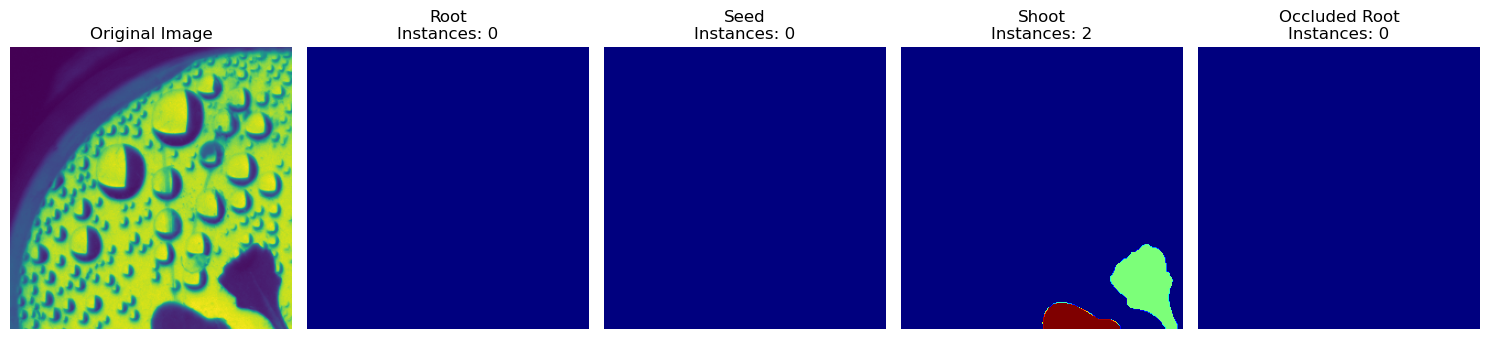

In [ ]:
# Visualize instance segmentation results
visualize_instance_segmentation(
    example_image,
    [root_mask, seed_mask, shoot_mask, occ_root_mask],
    ['Root', 'Seed', 'Shoot', 'Occluded Root']
)